In [58]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

sns.set(color_codes=True)
%matplotlib inline


In [16]:
df = pd.read_csv("after_merge.csv")
print("{} samples".format(df.shape[0]))


3066 samples


In [3]:
embedding_cols = ["F{}".format(i + 1) for i in range(512)]
exif_cols = [col for col in df.columns if "exif" in col]
feature_cols = embedding_cols + exif_cols
features = df.loc[:, feature_cols]

print("{} embedding features".format(len(embedding_cols)))
print("{} exif data features".format(len(exif_cols)))
print("{} features".format(features.shape[1]))

null_mask = features.isnull().sum() > 0
print("Removing {} features with more than 0 null values.".format(len(null_mask[null_mask])))
features = features.loc[:, ~null_mask]

print("Finalized {} features".format(features.shape[1]))


512 embedding features
41 exif data features
553 features
Removing 1 features with more than 0 null values.
Finalized 552 features


In [13]:
label_cols = [col for col in df.columns if "crs" in col]
labels = df.loc[:, label_cols]
print("Started with {} labels".format(labels.shape[1]))

no_tone_curve_cols = [col for col in labels.columns if "ToneCurve" not in col]
print("\nRemoving {} tone curve labels.".format(len(no_tone_curve_cols)))
labels = labels.loc[:, labels.columns.isin(no_tone_curve_cols)]

MIN_VAR = 0.1
low_var = labels.var() < MIN_VAR
print("\nRemoving {} labels with small variance.".format(len(low_var[low_var])))
print(low_var[low_var].index)
labels = labels.loc[:, ~low_var]

print("\nFinalized {} labels".format(labels.shape[1]))


Started with 165 labels

Removing 93 tone curve labels.

Removing 22 labels with small variance.
Index(['crs:ParametricDarks_0', 'crs:ParametricLights_0',
       'crs:ParametricHighlights_0', 'crs:PostCropVignetteAmount_0',
       'crs:LensManualDistortionAmount_0', 'crs:PerspectiveHorizontal_0',
       'crs:PerspectiveRotate_0', 'crs:PerspectiveAspect_0',
       'crs:PerspectiveUpright_0', 'crs:PerspectiveX_0', 'crs:PerspectiveY_0',
       'crs:AutoLateralCA_0', 'crs:DefringePurpleAmount_0',
       'crs:DefringeGreenAmount_0', 'crs:ToneMapStrength_0',
       'crs:ConvertToGrayscale', 'crs:UprightCenterMode_0',
       'crs:UprightCenterNormX_0', 'crs:UprightCenterNormY_0',
       'crs:UprightFocalMode_0', 'crs:UprightPreview',
       'crs:UprightFourSegmentsCount_0'],
      dtype='object')

Finalized 71 labels


In [5]:
# sns.jointplot(x=label_cols[3], y=label_cols[2], data=labels)

# corr = np.corrcoef(labels.values.T)
# corr[np.tril_indices(corr.shape[0])] = 0

# high_corrs = np.where(abs(corr) > 0.9)
# n_match = len(high_corrs[0])
# print(n_match)
# for i in range(n_match):
#     i1, i2 = high_corrs[0][i], high_corrs[1][i]
#     print("{},{}: {:.3f}".format(i1, i2, corr[i1, i2]))

# print(corr.shape)
# for i in range(corr.shape[0]):
#     for j in range(corr.shape[0]):
#         if i != j and corr[i, j] == 1:
#             print("{} and {}".format(no_tone_curve_cols[i], no_tone_curve_cols[j]))


In [6]:
categ = [col for col in labels.columns if len(labels[col].unique()) < 10]
print(len(categ))

n_uniques = [len(labels[col].unique()) for col in labels.columns]
sorted_n_uniques = sorted(zip(labels.columns, n_uniques), key=lambda e: e[1], reverse=True)
for col, n_unique in sorted_n_uniques[:20]:
    print("{}: {}".format(n_unique, col))

40
81: crs:Temperature_0
67: crs:Contrast2012_0
60: crs:Shadows2012_0
48: crs:Exposure2012_0
48: crs:Highlights2012_0
40: crs:Blacks2012_0
37: crs:Tint_0
30: crs:Whites2012_0
24: crs:Sharpness_0
23: crs:SaturationAdjustmentYellow_0
21: crs:SaturationAdjustmentOrange_0
20: crs:SaturationAdjustmentGreen_0
18: crs:Saturation_0
17: crs:SaturationAdjustmentRed_0
17: crs:SaturationAdjustmentBlue_0
16: crs:SplitToningShadowSaturation_0
15: crs:SplitToningShadowHue_0
14: crs:HueAdjustmentOrange_0
14: crs:HueAdjustmentYellow_0
12: crs:Vibrance_0


In [42]:
X = features.values


Train MSE: 444095.93393268524
Test  MSE: 4303620.363943612
R2: 0.7631019747769623


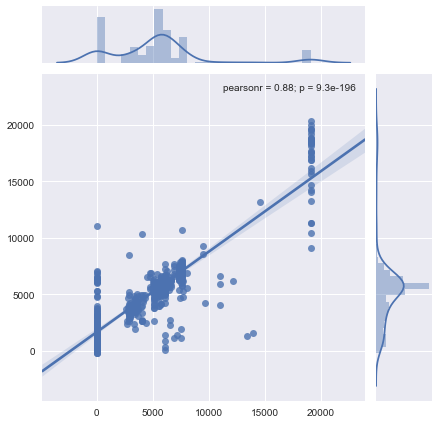

In [205]:
y = labels["crs:Temperature_0"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

clf = GradientBoostingRegressor(
    n_estimators=150,
    max_features=None,
    max_depth=4
)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
print("Train MSE: {}".format(mean_squared_error(y_train, y_pred_train)))

y_pred = clf.predict(X_test)
print("Test  MSE: {}".format(mean_squared_error(y_test, y_pred)))
print("R2: {}".format(r2_score(y_test, y_pred)))

sns.jointplot(x=y_test, y=y_pred, kind="reg")


Train MSE: 26.452780934859064
Test  MSE: 423.4572945132924
R2: 0.3903758568295924


,mean_test_score,mean_train_score,param_max_features,param_n_estimators,param_max_depth,rank_test_score
11,0.587888,0.983404,auto,100,6,1
13,0.585355,0.996405,None,50,10,2
8,0.585296,0.985337,None,100,6,3
17,0.581628,0.999949,auto,100,10,4
14,0.578530,0.999957,None,100,10,5
7,0.578400,0.933891,None,50,6,6
10,0.573403,0.928234,auto,50,6,7
16,0.573139,0.996494,auto,50,10,8
2,0.522495,0.786904,None,100,3,9
5,0.521486,0.786904,auto,100,3,10


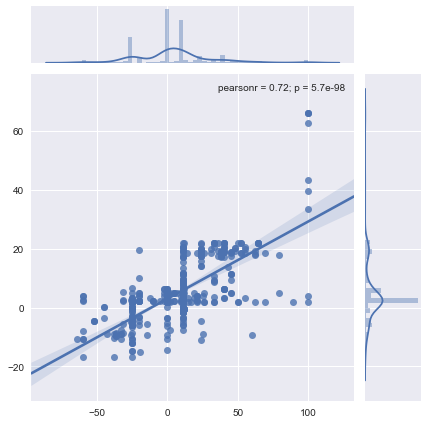

In [76]:
# y = labels["crs:Contrast2012_0"].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

params = {
    "n_estimators": [50, 100],
    "max_features": [None, "auto"],
    "max_depth": [3, 6, 10]
}

clf = GridSearchCV(GradientBoostingRegressor(), params, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
print("Train MSE: {}".format(mean_squared_error(y_train, y_pred_train)))

y_pred = grid.predict(X_test)
print("Test  MSE: {}".format(mean_squared_error(y_test, y_pred)))
print("R2: {}".format(r2_score(y_test, y_pred)))

sns.jointplot(x=y_test, y=y_pred, kind="reg")
desired_columns = ["mean_test_score", "mean_train_score"] +\
                    list(filter(lambda c: "param_" in c, clf.cv_results_.keys())) +\
                    list(filter(lambda c: "rank" in c, clf.cv_results_.keys()))
pd.DataFrame.from_dict(clf.cv_results_).loc[:, desired_columns].sort_values("rank_test_score")


Top 10 features and importances
0.023: F185
0.024: F380
0.026: F73
0.029: exif:ExposureTime_0
0.031: F339
0.033: exif:MeteringMode_0
0.033: exif:ShutterSpeedValue_0
0.039: exif:FNumber_0
0.042: exif:ApertureValue_0
0.051: exif:Flash/exif:Fired


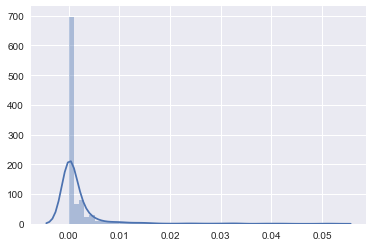

In [57]:
importance_inds = np.argsort(clf.feature_importances_)
sns.distplot(np.sort(clf.feature_importances_))
top_k = 10
print("Top {} features and importances".format(top_k))
for ind in importance_inds[-top_k:]:
    print("{:.3f}: {}".format(clf.feature_importances_[ind], feature_cols[ind]))